# SD212: Graph mining
## Lab 6: Diffusion in graphs

In this lab, you will learn to use diffusion for ranking and classifying the nodes of a graph. We only consider the Dirichlet approach.

## Import

In [1]:
from IPython.display import SVG

In [2]:
import numpy as np
from scipy import sparse

In [3]:
from sknetwork.data import load_netset, grid, karate_club
from sknetwork.classification import DirichletClassifier, BiDirichletClassifier
from sknetwork.ranking import Dirichlet, BiDirichlet, PageRank, BiPageRank, top_k
from sknetwork.utils import membership_matrix
from sknetwork.visualization import svg_graph

## Data

We will work on the following graphs (see the [NetSet](https://netset.telecom-paris.fr/) collection for details):
* Openflights (graph)
* WikiVitals (digraph)
* Cinema (bigraph)

In [4]:
openflights = load_netset('openflights')
wikivitals = load_netset('wikivitals')
cinema = load_netset('cinema')

Parsing files...
Done.
Parsing files...
Done.
Parsing files...
Done.


## 1. Graphs

## Grid

We first illustrate the ability of diffusion to rank nodes in the presence of hot sources and cold sources, as the solution to the Dirichlet problem.

In [5]:
k = 12
graph = grid(k, k, True)
adjacency = graph.adjacency
position = graph.position

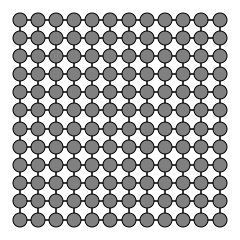

In [6]:
image = svg_graph(adjacency, position, width=200, height=200)
SVG(image)

## To do

* Display the solution to the Dirichlet problem with 1 hot source and 1 cold source, located on the ends of a diagonal.
* Add 1 hot source at a location of your choice and observe the result.
* Display the graph with hot sources on one diagonal of the square and 1 cold source on one end of the other diagonal of the square. What is the temperature of the other end of the diagonal? Observe the sensitivity of the result to the parameter ``n_iter`` of the object ``Dirichlet``.

In [7]:
dirichlet = Dirichlet()

In [8]:
first_diagonal = (k + 1) * np.arange(k)
second_diagonal = (k - 1) * (np.arange(k) + 1)

In [9]:
seeds = {first_diagonal[0]: 0, first_diagonal[-1]: 1}

In [10]:
scores = dirichlet.fit_transform(adjacency, seeds)

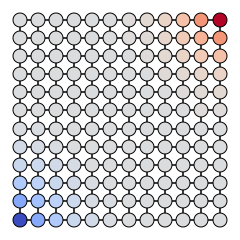

In [11]:
image = svg_graph(adjacency, position, scores=scores, width=200, height=200)
SVG(image)

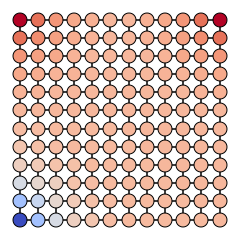

In [12]:
seeds = {first_diagonal[0]: 0, first_diagonal[-1]: 1}
seeds[second_diagonal[0]] = 1
scores = dirichlet.fit_transform(adjacency, seeds)
image = svg_graph(adjacency, position, scores=scores, width=200, height=200)
SVG(image)

In [13]:
seeds = dict()

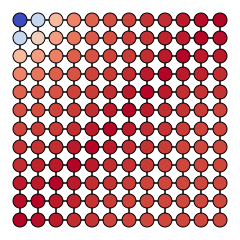

In [14]:
for i in first_diagonal : 
    seeds[i] = 1
seeds[second_diagonal[0]] = 0

scores = dirichlet.fit_transform(adjacency, seeds)
image = svg_graph(adjacency, position, scores=scores, width=200, height=200)
SVG(image)

In [15]:
scores[second_diagonal[-1]]

0.9230769230769231

0.9999999996146993


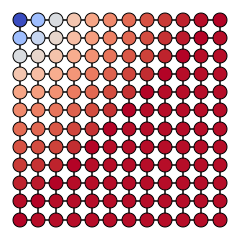

In [16]:
dirichlet = Dirichlet(n_iter = 1000)
scores = dirichlet.fit_transform(adjacency, seeds)
print(scores[second_diagonal[-1]])
image = svg_graph(adjacency, position, scores=scores, width=200, height=200)
SVG(image)

0.9230769230769231


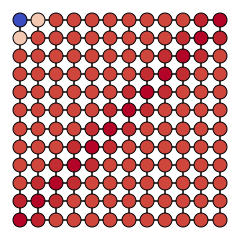

In [17]:
dirichlet = Dirichlet(n_iter = 1)
scores = dirichlet.fit_transform(adjacency, seeds)
print(scores[second_diagonal[-1]])
image = svg_graph(adjacency, position, scores=scores, width=200, height=200)
SVG(image)

## Karate Club


We now consider the classification of nodes by the Dirichlet method. We use the [karate club graph](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) that has ground-truth labels.

In [18]:
graph = karate_club(True)

In [19]:
adjacency = graph.adjacency
position = graph.position
labels_true = graph.labels

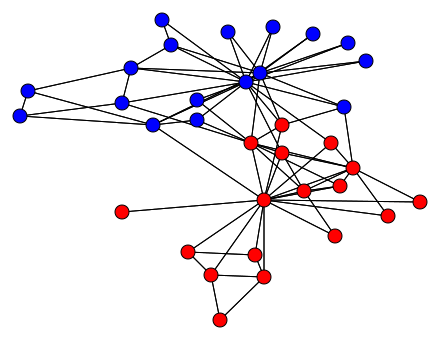

In [20]:
image = svg_graph(adjacency, position, labels=labels_true)
SVG(image)

## To do

* Select 2 seeds, one in each cluster, and display the graph with the predicted labels. What is the accuracy of the classification?
* Display the graph with the temperature of each node at equilibrium.
* Give the accuracy averaged over 100 experiments with 2 seeds selected at random, one in each cluster.
* Display the graph with the two most frequently misclassified nodes.

In [21]:
ind_1 = np.where(labels_true == 1)[0]
ind_0 = np.where(labels_true == 0)[0]
seeds = {ind_1[3] : 1, ind_0[3] : 0}

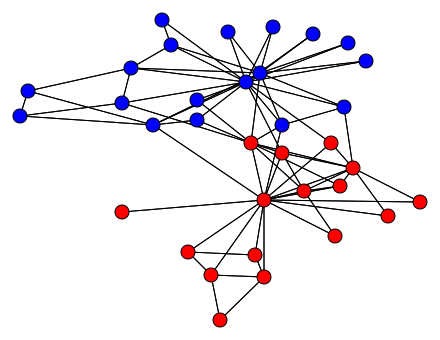

In [22]:
classifier = DirichletClassifier(n_iter=10)
labels = classifier.fit_transform(adjacency, seeds)
image = svg_graph(adjacency, position, labels=labels)
SVG(image)

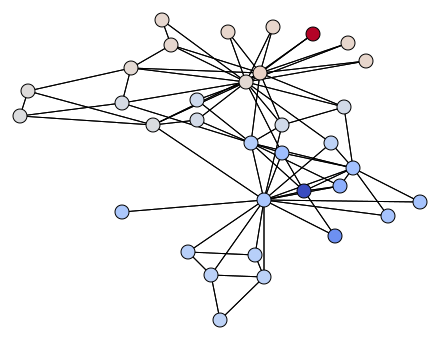

In [23]:
membership = classifier.membership_
scores = membership[:,0].toarray().ravel()
image = svg_graph(adjacency, position, scores=scores)
SVG(image)

In [24]:
errors = []
for i in range(100): 
    seeds = {ind_0[np.random.randint(len(ind_0))] : 0, ind_1[np.random.randint(len(ind_1))] : 1}
    classifier = DirichletClassifier(n_iter=10)
    labels = classifier.fit_transform(adjacency, seeds)
    for j in range(len(labels)):
        if labels[j]!= labels_true[j]: 
            errors.append(j)
            
print("Nombre d'erreurs moyen :", len(errors)/100)
uni, counts = np.unique(errors, return_counts=True)
ind = uni[np.argsort(counts)[[-2, -1]]]
print(ind)

Nombre d'erreurs moyen : 2.35
[2 8]


## Openflights


We now classify the nodes of a graph without labels, to get the local structure of the graph.

In [25]:
graph = openflights

In [26]:
adjacency = graph.adjacency
position = graph.position
names = graph.names

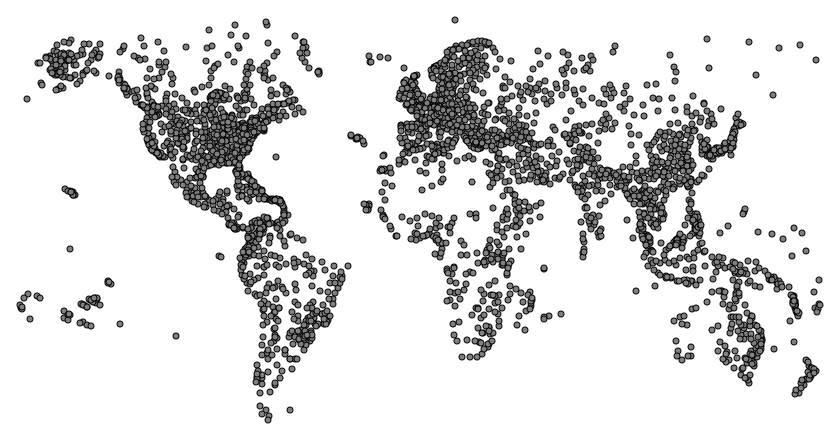

In [27]:
image = svg_graph(adjacency, position, width=800, height=400, node_size=3, display_edges=False)
SVG(image)

## To do

* Display the same world map with the labels predicted for 3 seeds (Paris, New-York, Beijing), each with its own  label.
* Add a seed in Madrid with another label and observe the result.

In [28]:
paris = 622
newyork = 1842
beijing = 1618
madrid = 572

In [29]:
classifier = DirichletClassifier()

In [30]:
seeds = {paris : 0, newyork : 1, beijing : 2}
labels = classifier.fit_transform(adjacency, seeds)
image = svg_graph(adjacency, position, labels=labels)
SVG(image)

In [31]:
seeds[madrid] = 3
labels = classifier.fit_transform(adjacency, seeds)
image = svg_graph(adjacency, position, labels=labels)
SVG(image)

## To do

* List the top-10 airports that are close to Tokyo and far from Paris using the Dirichlet method.
* Observe the scores and explain the result.
* Check your guess on displaying the following aggregate graph: Tokyo, top-10 airports except Tokyo, rest of the world.<br>**Hint:** Use the function ``membership_matrix``.

In [32]:
dirichlet = Dirichlet()

In [33]:
tokyo = 1084

In [34]:
seeds = {tokyo : 1, paris : 0}
scores = dirichlet.fit_transform(adjacency, seeds)
ind = np.argsort(scores)
print(names[ind[-10:]])

['Oshima Airport' 'Hachijojima Airport' 'Tokushima Airport'
 'Tottori Airport' 'Izumo Airport' 'Nanki Shirahama Airport'
 'Tokachi-Obihiro Airport' 'Monbetsu Airport' 'Shonai Airport'
 'Iwami Airport']


## 2. Directed graphs

## Wikipedia Vitals

In [35]:
graph = wikivitals

In [36]:
adjacency = graph.adjacency
names = graph.names

## To do

* List the top-10 articles that are close to **Cat** and **Dog** in terms of Personalized BiPageRank.
* Compare with the list of top-10 articles that are close to **Cat** and **Dog** and far from **Bear** and **Tiger** using diffusion.
* List the top-10 articles that are close to **Bear** and **Tiger** and far from **Cat** and **Dog**. **Hint:** You can use previous diffusion.

In [37]:
cat = 1401
dog = 1395
bear = 1390
tiger = 1410

In [38]:
pagerank = BiPageRank()

In [39]:
seeds = {cat : 1, dog : 1}
scores = pagerank.fit_transform(adjacency, seeds)
print(names[np.argsort(scores)[-10:]])

['Lion' 'Tiger' 'European badger' 'Wolf' 'Coyote' 'Pinniped' 'Brown bear'
 'Bear' 'Cat' 'Dog']


In [40]:
dirichlet = Dirichlet()

In [41]:
seeds[bear] = 0
seeds[tiger] = 0
scores = dirichlet.fit_transform(adjacency, seeds)
print(names[np.argsort(scores)[-10:]])

['Mouse' 'German Shepherd' 'Greyhound' 'Horned lizard' 'Retriever'
 'Siamese cat' 'Terrier' 'Domestic short-haired cat' 'Dog' 'Cat']


In [42]:
print(names[np.argsort(scores)[:10]])

['Bear' 'Tiger' 'Serranidae' 'Hibernation' 'Taxidermy' 'Mysore'
 'Mount St. Helens' 'Nanyue' 'Tapir' 'Endangered species']


## 3. Bipartite graphs

## Cinema

In [43]:
graph = cinema

In [44]:
biadjacency = graph.biadjacency
movies = graph.names_row
actors = graph.names_col

## To do

* List the top-20 movies that are close to **Taxi Driver** and **Drive** in terms of Personalized PageRank. What is the rank of **Finding Nemo**?
* List the top-20 movies that are close to **Taxi Driver** and **Drive** and far from **Finding Nemo** using diffusion.

In [45]:
pagerank = BiPageRank()

In [46]:
taxi = 63668
drive = 19744
nemo = 22770

In [47]:
seeds = {taxi : 1, drive : 1}
scores = pagerank.fit_transform(biadjacency, seeds)
print(movies[np.argsort(scores)[-20:]])

['Broadcast News' 'The Scout' 'Out of Sight' 'My First Mister'
 'Critical Care' 'The In-Laws (2003 film)' 'Concussion (2015 film)'
 'Unfaithfully Yours (1984 film)' 'This Is 40'
 'The Little Prince (2015 film)' 'The Secret Life of Pets'
 "I'll Do Anything" 'Inside Llewyn Davis' 'The Simpsons Movie'
 'Exploring the Reef' 'Finding Dory' 'Finding Nemo' 'A Most Violent Year'
 'Drive (2011 film)' 'Taxi Driver']


In [48]:
dirichlet = BiDirichlet()

In [49]:
seeds[nemo] = 0
scores = dirichlet.fit_transform(biadjacency, seeds)
print(movies[np.argsort(scores)[-5:]])

['Listen to Your Heart (2010 film)' 'Stormy Weathers (1992 film)'
 'Wildlife' 'Drive (2011 film)' 'Taxi Driver']
